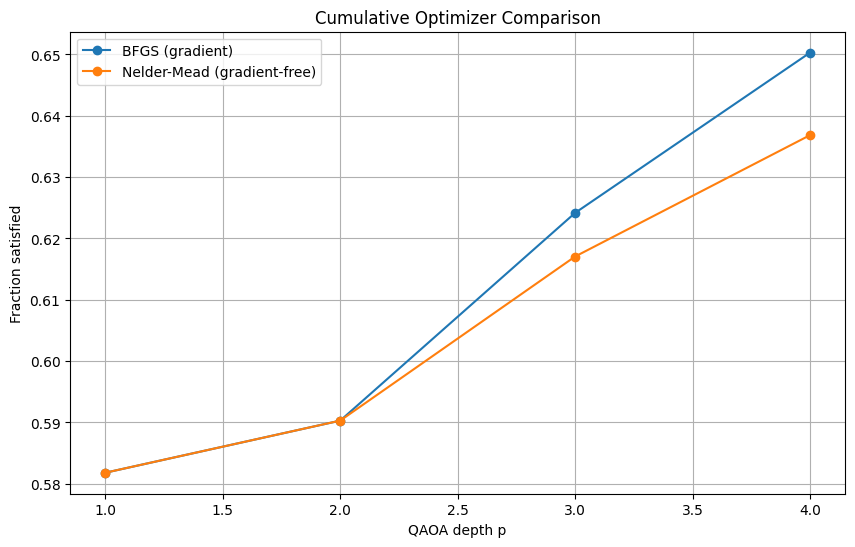

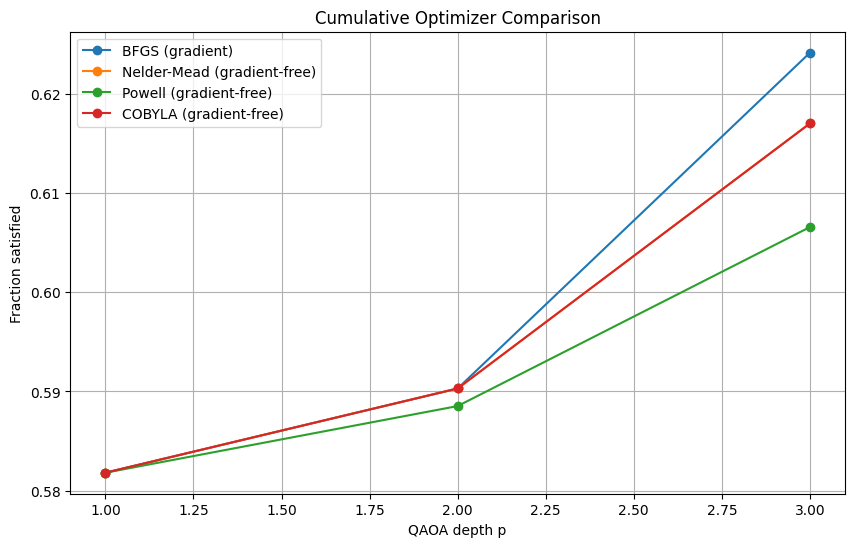

In [9]:
import os, math, logging, tkinter as tk
from tkinter import ttk
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from scipy.optimize import minimize, differential_evolution, basinhopping, shgo
from scipy.ndimage import uniform_filter1d

logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s - %(message)s")
LOGGER = logging.getLogger("qaoa")

@dataclass
class QAOAConfig:
    p: int = 3
    maxiter: int = 200
    runs: int = 3
    seed: int = 42
    backend_method: str = "statevector"
    backend_device: str = "AUTO"
    measure_shots: int = 0

@dataclass
class GraphConfig:
    n: int = 6
    d: int = 3
    ensure_connected: bool = True

def init_backend(method, device_pref):
    try:
        if device_pref.upper() in ["GPU","AUTO"]:
            os.environ["QISKIT_AER_USE_CUDA"]="1"
            return AerSimulator(method=method, device="GPU")
    except Exception:
        pass
    return AerSimulator(method=method, device="CPU")

def generate_graph(cfg, rng):
    while True:
        G = nx.random_regular_graph(d=cfg.d, n=cfg.n, seed=int(rng.integers(1,10_000)))
        if not cfg.ensure_connected or nx.is_connected(G): return G

def graph_cost(bitstring, edges):
    return sum(1 for u,v in edges if bitstring[u]!=bitstring[v]) / len(edges)

def build_qaoa(params,p,n_qubits,edges):
    qc=QuantumCircuit(n_qubits)
    gammas,betas=params[:p],params[p:]
    qc.h(range(n_qubits))
    for layer in range(p):
        for i,j in edges:
            qc.cx(i,j); qc.rz(2*gammas[layer],j); qc.cx(i,j)
        for i in range(n_qubits): qc.rx(2*betas[layer],i)
    return qc

class QAOAExecutor:
    def __init__(self,cfg):
        self.cfg=cfg
        self.backend=init_backend(cfg.backend_method,cfg.backend_device)
    def expectation(self,qc,edges):
        if self.cfg.measure_shots==0 and self.cfg.backend_method=="statevector":
            sv=Statevector.from_instruction(qc)
            return sum(p*graph_cost(bs,edges) for bs,p in sv.probabilities_dict().items())
        circ=qc.copy(); circ.measure_all()
        job=self.backend.run(circ,shots=max(1,self.cfg.measure_shots))
        counts=job.result().get_counts(); shots=sum(counts.values())
        return sum((c/shots)*graph_cost(bs,edges) for bs,c in counts.items())

OPTIMIZERS = {
    "BFGS":"gradient",
    "L-BFGS-B":"gradient",
    "CG":"gradient",
    "Newton-CG":"gradient",
    "SLSQP":"gradient",
    "Trust-Constr":"gradient",
    "Nelder-Mead":"gradient-free",
    "Powell":"gradient-free",
    "COBYLA":"gradient-free",
    "Differential Evolution":"gradient-free",
    "Basin-Hopping":"gradient-free",
    "SHGO":"gradient-free"
}

def optimize_qaoa(executor,p,n_qubits,edges,cfg,opt_name):
    rng=np.random.default_rng(cfg.seed)
    best=-np.inf
    def obj(x): return -executor.expectation(build_qaoa(x,p,n_qubits,edges),edges)
    bounds=[(0,math.pi)]*(2*p)
    for r in range(cfg.runs):
        init=rng.uniform(0,math.pi,2*p)
        if opt_name in ["BFGS","L-BFGS-B","CG","Newton-CG","SLSQP","Trust-Constr","Nelder-Mead","Powell","COBYLA"]:
            res=minimize(obj,init,method=opt_name,options={"maxiter":cfg.maxiter})
            val=-res.fun
        elif opt_name=="Differential Evolution":
            res=differential_evolution(obj,bounds,maxiter=cfg.maxiter)
            val=-res.fun
        elif opt_name=="Basin-Hopping":
            res=basinhopping(obj,init,niter=cfg.maxiter)
            val=-res.fun
        elif opt_name=="SHGO":
            res=shgo(obj,bounds,n=cfg.maxiter)
            val=-res.fun
        else:
            val=-np.inf
        if val>best: best=val
    return best

def run_comparison(selected_opts,p=3,runs=3,device="AUTO"):
    if not selected_opts:
        print("No optimizers selected.")
        return
    qcfg=QAOAConfig(p=p,runs=runs,backend_device=device)
    gcfg=GraphConfig()
    rng=np.random.default_rng(qcfg.seed)
    graph=generate_graph(gcfg,rng)
    executor=QAOAExecutor(qcfg)
    edges=list(graph.edges)
    depths=list(range(1,p+1))
    plt.figure(figsize=(10,6))
    for opt in selected_opts:
        vals=[optimize_qaoa(executor,d,graph.number_of_nodes(),edges,qcfg,opt) for d in depths]
        smoothed=np.maximum.accumulate(uniform_filter1d(vals,size=2))
        plt.plot(depths,smoothed,marker='o',label=f"{opt} ({OPTIMIZERS[opt]})")
    plt.xlabel("QAOA depth p"); plt.ylabel("Fraction satisfied")
    plt.title("Cumulative Optimizer Comparison")
    plt.legend(); plt.grid(True); plt.show()

# ---------------- Tkinter GUI ----------------
def launch_gui():
    root=tk.Tk()
    root.title("QAOA Optimizer Comparison")

    # Optimizer checkboxes
    selected_vars={}
    frame_opts=tk.LabelFrame(root,text="Select Optimizers")
    frame_opts.pack(fill="x",padx=5,pady=5)
    for opt in OPTIMIZERS.keys():
        var=tk.BooleanVar()
        cb=tk.Checkbutton(frame_opts,text=f"{opt} ({OPTIMIZERS[opt]})",variable=var)
        cb.pack(anchor="w")
        selected_vars[opt]=var

    # Depth slider
    frame_depth=tk.Frame(root); frame_depth.pack(fill="x",padx=5,pady=5)
    tk.Label(frame_depth,text="Max Depth p").pack(side="left")
    depth_var=tk.IntVar(value=3)
    tk.Scale(frame_depth,from_=1,to=10,orient="horizontal",variable=depth_var).pack(side="left")

    # Runs slider
    frame_runs=tk.Frame(root); frame_runs.pack(fill="x",padx=5,pady=5)
    tk.Label(frame_runs,text="Runs").pack(side="left")
    runs_var=tk.IntVar(value=3)
    tk.Scale(frame_runs,from_=1,to=10,orient="horizontal",variable=runs_var).pack(side="left")

    # Device dropdown
    frame_dev=tk.Frame(root); frame_dev.pack(fill="x",padx=5,pady=5)
    tk.Label(frame_dev,text="Device").pack(side="left")
    device_var=tk.StringVar(value="AUTO")
    ttk.Combobox(frame_dev,textvariable=device_var,values=["AUTO","CPU","GPU"]).pack(side="left")

    # Compare button
    def on_compare():
        selected=[opt for opt,var in selected_vars.items() if var.get()]
        run_comparison(selected,p=depth_var.get(),runs=runs_var.get(),device=device_var.get())

    tk.Button(root,text="Compare Selected",command=on_compare).pack(pady=10)

    root.mainloop()

if __name__=="__main__":
    launch_gui()